In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from CNNModel import create_CNN_model
import datetime
from sklearn.preprocessing import LabelEncoder

In [9]:
def test_png(images,base_dir):#select all the png file
  result=list()
  for i in images:
    if os.path.splitext(i)[1]==".png":
      temp=base_dir+'/'+i
      result.append(temp)
  return result

In [10]:
def build_df():# create DataFrame
	parasitized=os.path.join('./cell_images/Parasitized')#read file path
	uninfected=os.path.join('./cell_images/Uninfected')
	parasitized_image=test_png(os.listdir(parasitized),parasitized)#get name of files
	uninfected_image=test_png(os.listdir(uninfected),uninfected)
	df_infected=pd.DataFrame({'file_dir':parasitized_image,'infected':True})#create df, the infected is True
	df_uninfected=pd.DataFrame({'file_dir':uninfected_image,'infected':False})
	df=df_uninfected.append(df_infected)
	df=shuffle(df).reset_index(drop=True)
	return df

In [11]:
def calculate_best_size(df):#calculate optimal size
	img_shape=np.zeros((len(df),3))
	for i in range(len(df)):
		img=cv2.imread(df['file_dir'][i]).shape
		img_shape[i]=img
	print('Min Shape:', np.min(img_shape, axis=0)) 
	print('Max Shape:', np.max(img_shape, axis=0))
	print('Median Shape:', np.median(img_shape, axis=0))
	print('Avg Shape:', np.mean(img_shape, axis=0))
	return np.mean(img_shape,axis=0)

In [12]:
def re_size(df,avg_shape):#resize all the png
	img_shape=[int(avg_shape[0]),int(avg_shape[1])]
	img_data=list()
	for i in range(len(df)):
		img=cv2.resize(cv2.imread(df[i]),tuple(img_shape),interpolation=cv2.INTER_CUBIC)
		img = np.array(img, dtype=np.float32)
		img_data.append(img)
	return np.array(list(img_data))

In [13]:
def show_img(data_set,infected):#print img
	plt.figure()
	n=0
	for i in range(10):
		n+=1
		r=np.random.randint(0,data_set.shape[0],1)
		plt.subplot(2,5,n)
		plt.imshow(data_set[r[0]].astype('uint8'))
		plt.title('{}'.format(infected[r[0]]))
		plt.xticks([]),plt.yticks([])
	plt.show()


def get_callback():
	logdir = os.path.join('./test', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
	tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
	reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=2, min_lr=0.000001)
	return [reduce_lr, tensorboard_callback]

In [14]:
df=build_df()
avg_shape=calculate_best_size(df)

Min Shape: [40. 46.  3.]
Max Shape: [385. 394.   3.]
Median Shape: [130. 130.   3.]
Avg Shape: [132.98345308 132.48715437   3.        ]


In [15]:
#divide train，vaild，test to 60：10：30
train_set, test_set, train_infected, test_infected = train_test_split(df['file_dir'].values, df['infected'].values, test_size=0.3, random_state=42)
train_set, val_set, train_infected, val_infected = train_test_split(train_set, train_infected, test_size=0.1, random_state=42)

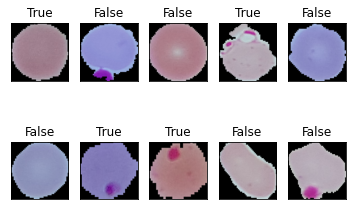

In [16]:
train_data=re_size(train_set,avg_shape)
show_img(train_data,train_infected)
val_data=re_size(val_set,avg_shape)
test_data=re_size(test_set,avg_shape)

In [17]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(17361, 132, 132, 3)
(8268, 132, 132, 3)
(1929, 132, 132, 3)


In [23]:
#CNN model Pre-Set
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (132, 132, 3)
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.
label_encoder = LabelEncoder()
label_encoder.fit(train_infected)
train_labels_enc = label_encoder.transform(train_infected)
val_labels_enc = label_encoder.transform(val_infected)
callbacks = get_callback()
print(train_infected[:6], train_labels_enc[:6])

[ True False False  True False False] [1 0 0 1 0 0]


In [40]:
import tensorflow as tf

def create_CNN_model(shape):
	model = tf.keras.models.Sequential()
	model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=shape))
	model.add(tf.keras.layers.MaxPooling2D((2, 2)))
	model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
	model.add(tf.keras.layers.MaxPooling2D((2, 2)))
	model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
	model.add(tf.keras.layers.MaxPooling2D((2, 2)))
	model.add(tf.keras.layers.Flatten())
	model.add(tf.keras.layers.Dense(128, activation='relu'))
	model.add(tf.keras.layers.Dropout(rate=0.8))
	model.add(tf.keras.layers.Dense(128, activation='relu'))
	model.add(tf.keras.layers.Dropout(rate=0.8))
	model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
	model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

	return model

In [41]:
CNN_model = create_CNN_model(INPUT_SHAPE)

In [42]:
model = CNN_model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/25
272/272 [==============================] - 146s 538ms/step - loss: 0.6980 - accuracy: 0.5012 - val_loss: 0.6915 - val_accuracy: 0.5293 - lr: 0.0010
Epoch 2/25
272/272 [==============================] - 147s 540ms/step - loss: 0.6899 - accuracy: 0.5286 - val_loss: 0.6796 - val_accuracy: 0.5692 - lr: 0.0010
Epoch 3/25
272/272 [==============================] - 145s 535ms/step - loss: 0.5799 - accuracy: 0.6958 - val_loss: 0.4333 - val_accuracy: 0.9425 - lr: 0.0010
Epoch 4/25
272/272 [==============================] - 145s 535ms/step - loss: 0.2707 - accuracy: 0.9279 - val_loss: 0.1985 - val_accuracy: 0.9383 - lr: 0.0010
Epoch 5/25
272/272 [==============================] - 147s 539ms/step - loss: 0.1893 - accuracy: 0.9476 - val_loss: 0.1736 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 6/25
272/272 [==============================] - 144s 529ms/step - loss: 0.1685 - accuracy: 0.9520 - val_loss: 0.1531 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 7/25
272/272 [==========================

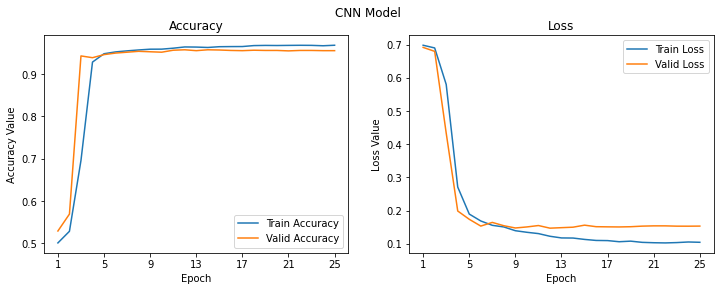

In [43]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Model', fontsize=12)
#f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,len(model.history['accuracy'])+1))
ax1.plot(epoch_list, model.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, model.history['val_accuracy'], label='Valid Accuracy')
ax1.set_xticks(np.arange(1, len(model.history['accuracy'])+1, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(epoch_list, model.history['loss'], label='Train Loss')
ax2.plot(epoch_list, model.history['val_loss'], label='Valid Loss')
ax2.set_xticks(np.arange(1, len(model.history['accuracy'])+1, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
ax2.legend()
plt.savefig("result.png")